In [1]:
import numpy as np
import json
import os
import random
import matplotlib.pyplot as plt

## Loading data to use as reference (annotazioni fatte a mano da Andrea)

In [2]:
annotations_qa_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_qa/texts'
with open(os.path.join(annotations_qa_root, 'spatial_gpt4point_qa_no_vec.json'), 'r') as f:
    annotations_qa = json.load(f)
print(len(annotations_qa))
print(annotations_qa[0])  

annotations_cap_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_cap/texts'
with open(os.path.join(annotations_cap_root, 'spatial_gpt4point_cap.json'), 'r') as f:
    annotations_cap = json.load(f)
print(len(annotations_cap))
print(annotations_cap[0])

data_root = '/media/data7/DATASET/objanerf_text_evaluation_data/imgs_from_objaverse/gpt4point_test'

190
{'object_id': '44795759d6144f61990796c02088665f', 'conversations': [{'from': 'human', 'value': 'What is the rabbit wearing around its neck?\nA: A red necklace\nB: A red tie\nC: A red scarf'}, {'from': 'gpt', 'value': 'C: A red scarf'}]}
100
{'object_id': '1915ece903a5406d8b59b3af3954b943', 'conversations': [{'from': 'human', 'value': '<point>\nProvide a very detailed description of the object knowing that its caption is: "A low-polygon, golden trophy with a small handle base.". Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.'}, {'from': 'gpt', 'value': "The trophy is a three-dimensional object with a smooth, golden surface. It has a cylindrical body with a slightly flared top and a very thin circular base. The trophy has two handles: one on each side. The trophy's design is simplistic, with no visible textures or patterns, giving it a uniform a

In [3]:
object_ids = [annotation['object_id'] for annotation in annotations_qa]
object_ids = list(set(object_ids))
print(len(object_ids))

random_id = random.choice(object_ids)
print(random_id)

98
a47c3ab11ffa49448fb38fa235d6541c


ba341c4ce89647ea9f6996ec58e3eacf
Q 1: Where are the tractors located in relation to each other?
A: Next to each other
B: One on one side of the scene and one on the other
C: One behind the other
====  A: Next to each other  ==== 


Question: <point>
Provide a very detailed description of the object knowing that its caption is: A scene with two tractors, a loader, and a trailer parked on a plot of land with plenty of wood waiting to be loaded.. Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.
GT:  This is a 3D scene with two tractors, a loader, and a trailer parked on a plot of land with plenty of wood waiting to be loaded. The tractors are positioned side by side, with the loader attached to one of them. The trailer is parked in front of the tractors, and the wood is stacked neatly beside the tractors. The ground appears to be a mix of dirt and patc

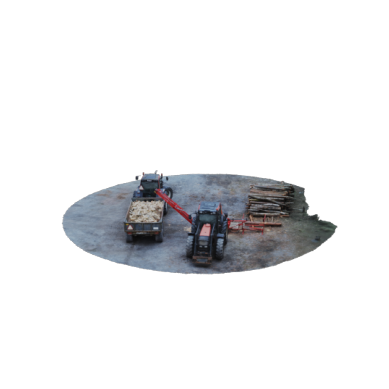

In [4]:
random_id = "ba341c4ce89647ea9f6996ec58e3eacf"

qa = [annotation for annotation in annotations_qa if annotation['object_id'] == random_id]
cap = [annotation for annotation in annotations_cap if annotation['object_id'] == random_id]
#print('QA annotations:', qa[0]['conversations'][0]['value'])
print(random_id)
for i, q in enumerate(qa):
    print(f'Q {i+1}: {q["conversations"][0]["value"]}')
    print('==== ', q['conversations'][1]['value'], ' ==== ')
    print('\n')

print('Question:', cap[0]['conversations'][0]['value'])
print('GT: ', cap[0]['conversations'][1]['value'])
image_path = os.path.join(data_root, random_id, '018.png')
plt.imshow(plt.imread(image_path))
plt.axis('off')
plt.show()

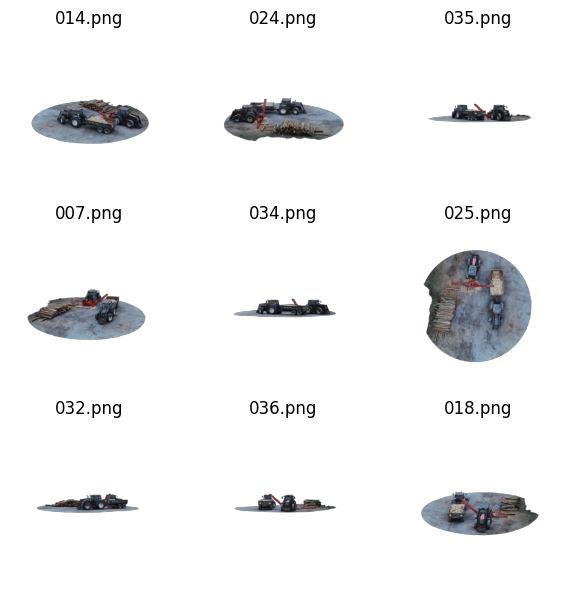

In [5]:
# visualize a grid with all the images of the object
def visualize_object_images(object_id, data_root, num_images=9):
    object_path = os.path.join(data_root, object_id)
    image_files = [f for f in os.listdir(object_path) if f.endswith('.png')]
    random.shuffle(image_files)
    image_files = image_files[:num_images]

    fig, axs = plt.subplots(3, 3, figsize=(6, 6))
    axs = axs.flatten()

    for ax, img_file in zip(axs, image_files):
        img_path = os.path.join(object_path, img_file)
        ax.imshow(plt.imread(img_path))
        ax.axis('off')
        ax.set_title(img_file)

    plt.tight_layout()
    plt.show()

visualize_object_images(random_id, data_root, num_images=9)

# Run VLM on input images

In [6]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from transformers import pipeline
import torch

/home/mgaliazzo/.pyenv/versions/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
os.system('export CUDA_HOME=/usr/local/cuda-12.4')
os.system('export PATH=$CUDA_HOME/bin:$PATH')
os.system('export LD_LIBRARY_PATH=$CUDA_HOME/lib64:$LD_LIBRARY_PATH')

0

In [8]:
model_id = "llava-hf/llava-interleave-qwen-7b-hf"
# bnb_config = BitsAndBytesConfig(
#         load_in_4bit=True,
#         bnb_4bit_use_double_quant=True,
#         bnb_4bit_quant_type="nf4",
#         bnb_4bit_compute_dtype=torch.float16)

# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,
#     bnb_4bit_compute_dtype=torch.float16
# )

In [9]:
# load LLaVA model

device = 'cuda:2'
llava = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    low_cpu_mem_usage=True, 
    # quantization_config=bnb_config, 
    device_map="auto"
).eval()

Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


In [10]:
llava_processor = AutoProcessor.from_pretrained(model_id)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
cap[0]['conversations'][1]['value']

'This is a 3D scene with two tractors, a loader, and a trailer parked on a plot of land with plenty of wood waiting to be loaded. The tractors are positioned side by side, with the loader attached to one of them. The trailer is parked in front of the tractors, and the wood is stacked neatly beside the tractors. The ground appears to be a mix of dirt and patches of grass, and there are no visible signs of recent activity, suggesting the scene might be a still moment in time.'

In [12]:
# random_ids = ["ba341c4ce89647ea9f6996ec58e3eacf"]
random_ids = []
for i in range(8):
    random_ids.append(random.choice(object_ids))

print(random_ids)

['f93bb826f374423681a4772a3c49c1df', 'f8a87e1da0d54ed285c60cf5dc3d77e7', '58cd445c1e0044dd8af2009d51b7be18', '05068915ce654951910e905e24e35d38', '5bd2cda8deb04409bd0b4272966be972', '99565b63b54d429f99526428639037bf', '05068915ce654951910e905e24e35d38', '569b72c271c44106a3caa51f7d32dcd6']


# SIMPLE GENERATION WITHOUT ADDITIONAL INFORMATION

image_names = ['000.png', '010.png', '015.png', '020.png']
data_root = "media7link/gpt4point_test/"
question = f"""
### Task:
Generate one multiple-choice question about the object(s) or scene depicted in the provided images.

### Constraints:
1.  **Detailed Questions:** The questions should require careful observation of the image.
2.  **Distinct Options:** Provide three distinct options for the question.
3.  **One Correct Answer:** Only one option must be clearly correct based on the image.

### Output Format:
For the question-answer pair, you MUST follow this format:
Q: [Your Question Text Here]
A. [Option 1 Text]
B. [Option 2 Text]
C. [Option 3 Text]
[Correct Option Letter]. [Correct Option]

Now, based on the provided images, generate a question and the relative answer following all the above instructions and the specified format.
"""
body_html = ""

random_id = "ba341c4ce89647ea9f6996ec58e3eacf"

for i in range(8):
    images = [os.path.join(data_root, random_ids[i], img_name) for img_name in image_names]

    # build conversation
    conversation = [
                    {
                        "role": "user",
                        "content": [
                            *[{"type": "image", "image": img} for img in images],
                            {"type": "text", "text": question}
                        ],
                    }
                ]
                
    # Process with VLM
    inputs = llava_processor.apply_chat_template(
        [conversation], 
        add_generation_prompt=True, 
        tokenize=True, 
        return_dict=True, 
        return_tensors="pt"
    ).to(device)

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate with optimized parameters
    # generate_ids = llava.generate(**inputs, max_new_tokens=128)
    generate_ids = llava.generate(**inputs, max_new_tokens=128, do_sample=True, temperature=0.05)
    outputs = llava_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    
    model_response = outputs[0].split('\n\nassistant\n', 1)[1]

    images_html = ""

    for imagepath in images:
        images_html += f"""<img src="{imagepath}" style="width:200px;" alt="{imagepath}">"""

    output_html = f"""<pre class="pre-wrap">{model_response}</pre>"""

    body_html += images_html + f"\n<p>ID: {random_id}</p>\n" + output_html + "\n"
    random_id = random.choice(object_ids)

full_html_path = "llavagen.html"

full_html = f"""
<!DOCTYPE html>
<html>
<head>
<title>LLaVA generation output</title>
  <style>
    .pre-wrap {{
      white-space: pre-wrap;   /* Preserves whitespace and wraps text */
      word-wrap: break-word;   /* Ensures long words break */
      max-width: 800px;          /* Maximum width (could also use px or rem) */
    }}
  </style>
</head>
<body>
<h2>Prompt:</h2>
<pre>{question}</pre>
<h2>Outputs:</h2>
{body_html}
</body>
</html> 
"""

with open(full_html_path, "w", encoding="utf-8") as f:
    f.write(full_html)


# ONE SHOT LEARNING ATTEMPT

image_names = ['000.png', '010.png', '015.png', '020.png']
data_root = "media7link/gpt4point_test/"
question = f"""
### Task:
Generate one multiple-choice question about the object(s) or scene depicted in the provided images, as done in the example you were just given.

### Constraints:
1.  **Detailed Questions:** The questions should require careful observation of the image.
2.  **Distinct Options:** Provide three distinct options for the question.
3.  **One Correct Answer:** Only one option must be clearly correct based on the image.

### Output Format:
For the question-answer pair, you MUST follow this format:
Q: [Your Question Text Here]
A. [Option 1 Text]
B. [Option 2 Text]
C. [Option 3 Text]
[Correct Option Letter]. [Correct Option Text]

Now, based on the provided images and the example, generate a question and the relative answer following all the above instructions and the specified format.
"""
question = """
Please output a new QnA for the new images you will be given. Take as a style reference the previous QnA related to the previous images, but don't make the question about the old scene, make it about the new scene.
Follow this format for the question-answer pair (like in the example above):
Q: [Your Question Text Here]
A. [Option 1 Text]
B. [Option 2 Text]
C. [Option 3 Text]
[Correct Option Letter]. [Correct Option Text]

Use the tractor scene just as an example on how you should structure your outputs. Don't reproduce the tractor QnA, make a new one for the new images.
"""
body_html = ""

example_id = "ba341c4ce89647ea9f6996ec58e3eacf"
example_qa = ""
example_images = [os.path.join(data_root, example_id, img_name) for img_name in image_names]
qa = [annotation for annotation in annotations_qa if annotation['object_id'] == example_id]
for i, q in enumerate(qa):
    example_qa += f'Q: {q["conversations"][0]["value"]}'
    example_qa += '\n' + q['conversations'][1]['value'] + '\n'

for i in range(8):
    images = [os.path.join(data_root, random_ids[i], img_name) for img_name in image_names]

    # build conversation
    conversation = [
                    {
                        "role": "user",
                        "content": [
                            *[{"type": "image", "image": img} for img in example_images],
                            {"type": "text", "text": example_qa},
                            {"type": "text", "text": question},
                            *[{"type": "image", "image": img} for img in images]
                        ],
                    }
                ]
                
    # Process with VLM
    inputs = llava_processor.apply_chat_template(
        [conversation], 
        add_generation_prompt=True, 
        tokenize=True, 
        return_dict=True, 
        return_tensors="pt"
    ).to(device)

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate with optimized parameters
    # generate_ids = llava.generate(**inputs, max_new_tokens=128)
    generate_ids = llava.generate(**inputs, max_new_tokens=128, do_sample=True, temperature=0.2)
    outputs = llava_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    
    model_response = outputs[0].split('\n\nassistant\n', 1)[1]

    images_html = ""

    for imagepath in images:
        images_html += f"""<img src="{imagepath}" style="width:200px;" alt="{imagepath}">"""

    output_html = f"""<pre class="pre-wrap">{model_response}</pre>"""

    body_html += images_html + f"\n<p>ID: {random_id}</p>\n" + output_html + "\n"
    random_id = random.choice(object_ids)

example_images_html = ""
for imagepath in example_images:
    example_images_html += f"""<img src="{imagepath}" style="width:200px;" alt="{imagepath}">"""

full_html_path = "llavagenoneshot.html"

full_html = f"""
<!DOCTYPE html>
<html>
<head>
<title>LLaVA generation output</title>
  <style>
    .pre-wrap {{
      white-space: pre-wrap;   /* Preserves whitespace and wraps text */
      word-wrap: break-word;   /* Ensures long words break */
      max-width: 800px;          /* Maximum width (could also use px or rem) */
    }}
  </style>
</head>
<body>
<h2>Prompt:</h2>
{example_images_html}\n
<pre>{example_qa} {question}</pre>
<h2>Outputs:</h2>
{body_html}
</body>
</html> 
"""

with open(full_html_path, "w", encoding="utf-8") as f:
    f.write(full_html)


# 3 SHOT LEARNING ATTEMPT

image_names = ['000.png', '010.png', '015.png', '020.png']
data_root = "media7link/gpt4point_test/"

# prompt = """
# Please based on the images and QnA i just gave you for the scene with the tractors output a new QnA for the new images.
# Follow this format for the question-answer pair (like in the example):
# Q: [Your Question Text Here]
# A. [Option 1 Text]
# B. [Option 2 Text]
# C. [Option 3 Text]
# [Correct Option Letter]. [Correct Option Text]

# Use the tractor scene just as an example on how you should structure your outputs. Don't reproduce the tractor QnA, make a new one for the new images.
# """

prompt = """
Please output a new QnA for the new images you will be given. Take as a style reference the previous QnA related to the previous images, but don't make the question about the old scene, make it about the new scene.
Follow this format for the question-answer pair (like in the example above):
Q: [Your Question Text Here]
A. [Option 1 Text]
B. [Option 2 Text]
C. [Option 3 Text]
[Correct Option Letter]. [Correct Option Text]

Use the scene just as an example on how you should structure your outputs. Don't reproduce the QnA, make a new one for the new images.
"""
body_html = ""
prompt_html = ""

example_images_list = []
example_qa_list = []
for i in range(3):
    # example_id = "ba341c4ce89647ea9f6996ec58e3eacf"
    example_id = random.choice(object_ids)

    # get the images for the example
    example_images = [os.path.join(data_root, example_id, img_name) for img_name in image_names]
    example_images_list.append(example_images)
    example_images_html = ""
    for imagepath in example_images:
        example_images_html += f"""<img src="{imagepath}" style="width:200px;" alt="{imagepath}">\n"""
    
    # text of the qa of the current example
    qa = [annotation for annotation in annotations_qa if annotation['object_id'] == example_id]
    example_qa = f'Q: {qa[0]["conversations"][0]["value"]}\n{qa[0]["conversations"][1]["value"]}\n'
    example_qa_list.append(example_qa)
    example_qa_html = "<pre>" + example_qa + "</pre>"
    
    prompt_html += f"{example_images_html}\n<pre>{example_id}</pre>\n{example_qa_html}"

for i in range(5):
    images = [os.path.join(data_root, random_ids[i], img_name) for img_name in image_names]

    # build conversation
    conversation = [
                    {
                        "role": "user",
                        "content": [
                            *[{"type": "image", "image": img} for img in example_images_list[0]],
                            {"type": "text", "text": example_qa_list[0]},
                            *[{"type": "image", "image": img} for img in example_images_list[0]],
                            {"type": "text", "text": example_qa_list[1]},
                            *[{"type": "image", "image": img} for img in example_images_list[0]],
                            {"type": "text", "text": example_qa_list[2]},
                            {"type": "text", "text": prompt},
                            *[{"type": "image", "image": img} for img in images]
                        ],
                    }
                ]
                
    # Process with VLM
    inputs = llava_processor.apply_chat_template(
        [conversation], 
        add_generation_prompt=True, 
        tokenize=True, 
        return_dict=True, 
        return_tensors="pt"
    ).to(device)

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate with optimized parameters
    # generate_ids = llava.generate(**inputs, max_new_tokens=128)
    generate_ids = llava.generate(**inputs, max_new_tokens=128, do_sample=True, temperature=0.2)
    outputs = llava_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    
    model_response = outputs[0].split('\n\nassistant\n', 1)[1]

    images_html = ""

    for imagepath in images:
        images_html += f"""<img src="{imagepath}" style="width:200px;" alt="{imagepath}">"""

    output_html = f"""<pre class="pre-wrap">{model_response}</pre>"""

    body_html += images_html + f"\n<p>ID: {random_id}</p>\n" + output_html + "\n"
    random_id = random.choice(object_ids)


full_html_path = "llavagen3shot.html"

full_html = f"""
<!DOCTYPE html>
<html>
<head>
<title>LLaVA generation output</title>
  <style>
    .pre-wrap {{
      white-space: pre-wrap;   /* Preserves whitespace and wraps text */
      word-wrap: break-word;   /* Ensures long words break */
      max-width: 800px;          /* Maximum width (could also use px or rem) */
    }}
  </style>
</head>
<body>
<h2>Prompt:</h2>
{prompt_html}
<h2>Outputs:</h2>
{body_html}
</body>
</html> 
"""

with open(full_html_path, "w", encoding="utf-8") as f:
    f.write(full_html)


qa[0]["conversations"][0]["value"]

qa[0]['conversations'][1]['value']

# BACK TO BASICS: DETAILED DESCRIPTIONS
things to test:
1. generate without help and with help (brief human description). description is found in `gpt4point_test_no_vec.json`
2. try to generate by formatting in a better way (like with the 3-shot example)
3. generate without quantization and then with 8 bit quantization. which one is better?

In [ ]:
image_names = ['000.png', '010.png', '015.png', '020.png']
data_root = "media7link/gpt4point_test/"
basic_object_description_path = "gpt4point_test_no_vec.json"

import json

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def get_gpt_answer_by_object_id(data, object_id):
    for item in data:
        if item["object_id"] == object_id:
            for conversation in item["conversations"]:
                if conversation["from"] == "gpt":
                    return conversation["value"]
    return "Object ID not found."

gpt4point_basic_descriptions = load_json(basic_object_description_path)

# NO DESCRIPTION, BY ME
# question = f"""
# Provide a very detailed description of the object you see in the images. Focus on the relative positions of the parts of the object. Include as many details as possible. Focus only on the content of the images. Focus only on the foreground.
# """

body_html = ""

random_id = "ba341c4ce89647ea9f6996ec58e3eacf"

for i in range(8):
    # BASIC HUMAN DESCRIPTION, BY ME
    gpt_basic_description = get_gpt_answer_by_object_id(gpt4point_basic_descriptions, object_id)
    question = f"""
    Provide a very detailed description of the object knowing that its caption is: "{gpt_basic_description}". Focus on the relative positions of the parts of the object. Include as many details as possible. Focus only on the content of the images. Focus only on the foreground.
    """

    images = [os.path.join(data_root, random_id, img_name) for img_name in image_names]

    # build conversation
    conversation = [
                    {
                        "role": "user",
                        "content": [
                            *[{"type": "image", "image": img} for img in images],
                            {"type": "text", "text": question}
                        ],
                    }
                ]

    # Process with VLM
    inputs = llava_processor.apply_chat_template(
        [conversation], 
        add_generation_prompt=True, 
        tokenize=True, 
        return_dict=True, 
        return_tensors="pt"
    ).to(device)

    # Move inputs to device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    total_tokens = inputs['input_ids'].shape[-1]
    print("Total tokens in prompt (including image placeholders):", total_tokens)

    # Generate with optimized parameters
    # generate_ids = llava.generate(**inputs, max_new_tokens=128)
    generate_ids = llava.generate(**inputs, max_new_tokens=128, do_sample=True, temperature=0.05)
    outputs = llava_processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    
    model_response = outputs[0].split('\n\nassistant\n', 1)[1]

    images_html = ""

    for imagepath in images:
        images_html += f"""<img src="{imagepath}" style="width:200px;" alt="{imagepath}">\n"""

    output_html = f"""<pre class="pre-wrap">{model_response}</pre>"""

    body_html += images_html + f"\n<p>ID: {random_id}</p>\n" + output_html + "\n"
    random_id = random.choice(object_ids)

full_html_path = "llavagen_noquant.html"

full_html = f"""
<!DOCTYPE html>
<html>
<head>
<title>LLaVA generation output</title>
  <style>
    .pre-wrap {{
      white-space: pre-wrap;   /* Preserves whitespace and wraps text */
      word-wrap: break-word;   /* Ensures long words break */
      max-width: 800px;          /* Maximum width (could also use px or rem) */
    }}
  </style>
</head>
<body>
<h2>Prompt:</h2>
<pre class="pre-wrap">{question}</pre>
<h2>Outputs:</h2>
{body_html}
<h3>Annotations on the generation:</h3>

</body>
</html> 
"""

with open(full_html_path, "w", encoding="utf-8") as f:
    f.write(full_html)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Total tokens in prompt (including image placeholders): 2973


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Total tokens in prompt (including image placeholders): 2973


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Total tokens in prompt (including image placeholders): 2973


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Total tokens in prompt (including image placeholders): 2973


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Total tokens in prompt (including image placeholders): 2973


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Total tokens in prompt (including image placeholders): 2973


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Total tokens in prompt (including image placeholders): 2973


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Total tokens in prompt (including image placeholders): 2973
